In [15]:
from fastai.vision import *
from fastai.vision. gan import *

In [16]:
path_hr = "HR/" 
path_lr = "LR/" 

In [17]:
import shutil


def remove_dir(name):
  try:
      shutil.rmtree(name)
  except OSError:
      print ("Couldn't remove the directory")
  else:
      print ("Successfully removed the directory")

In [18]:
import os

def create_dir(name):
  #rm -rf name
  # define the name of the directory to be created
  try:
      os.mkdir(name)
  except OSError:
      print ("Creation of the directory failed")
  else:
      print ("Successfully created the directory")

Generator


In [19]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [20]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr+x.name)
           #.transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs, no_check=True).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [50]:
bs,size = 2, 400
arch = models.resnet34

In [23]:
data_gen = get_data(bs,size)

In [24]:
print(data_gen)

ImageDataBunch;

Train: LabelList (720 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: LR;

Valid: LabelList (80 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: LR;

Test: None


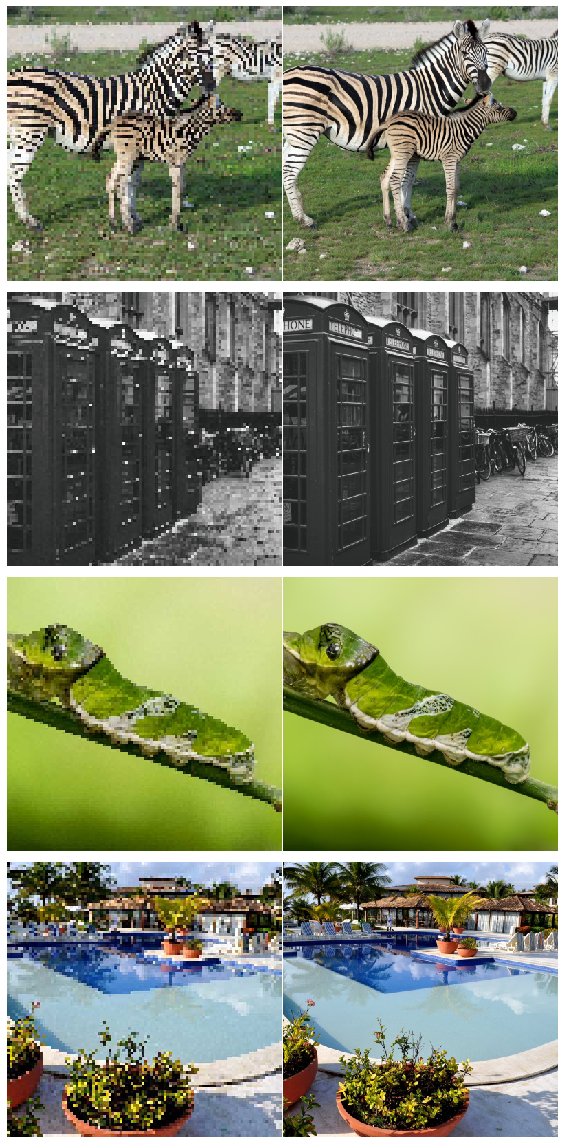

In [25]:
data_gen.show_batch(5)

In [29]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()
arch = models.resnet34

In [30]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [31]:
learn_gen = create_gen_learner()

Training U-net

skip if pretrained in U-net notebook

In [32]:
learn_gen.fit_one_cycle(4, pct_start=0.8)

In [33]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(5, slice(1e-6,1e-3))

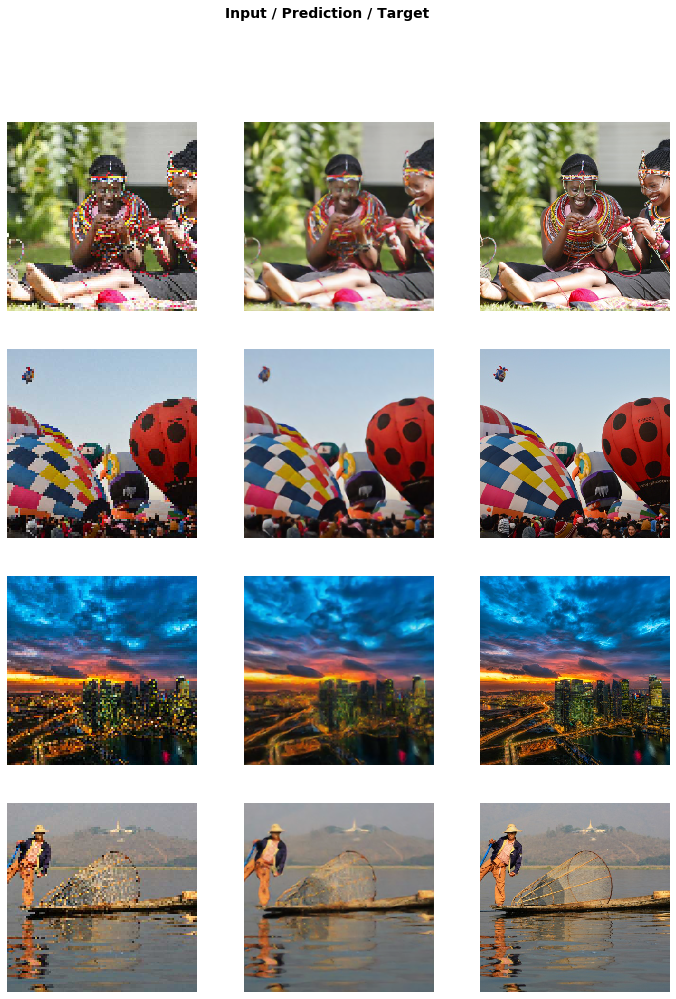

In [34]:
learn_gen.show_results(rows=5)

In [35]:
learn_gen.save('gen-pretrained')

Critic

In [36]:
learn_gen.load('gen-pretrained');

In [37]:
name_gen = 'image_gen'
name_images = 'HR'
path = "Critic"
path_gen = path + '/' + name_gen

In [38]:
remove_dir(path_gen)
create_dir(path_gen)

Couldn't remove the directory
Successfully created the directory


In [55]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen + '/' + names[i].name)
            i += 1

In [56]:
save_preds(data_gen.fix_dl)

In [57]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes = classes)
    data = (ll#.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [58]:
data_crit = get_crit_data([name_gen, name_images], bs=bs, size=size)

/usr/local/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
Critic
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.6/site-packages/fastai/data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Critic
  if getattr(ds, 'warn', False): warn(ds.warn)


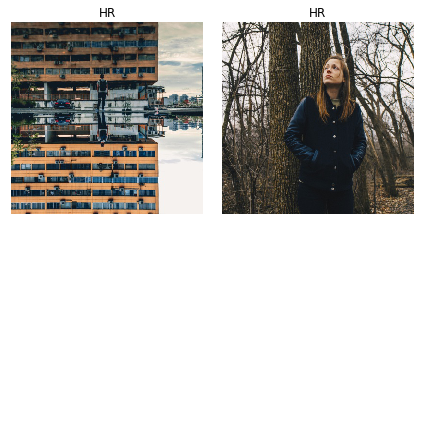

In [59]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [60]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [61]:
def create_critic_learner(data_cr, metrics):
    return Learner(data_cr, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [62]:
learn_critic = create_critic_learner(data_crit, None)

In [63]:
learn_critic.data

ImageDataBunch;

Train: LabelList (1371 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
image_gen,image_gen,image_gen,image_gen,image_gen
Path: Critic;

Valid: LabelList (149 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
HR,image_gen,image_gen,HR,image_gen
Path: Critic;

Test: None

In [ ]:
gc.collect()

In [ ]:
learn_critic.fit_one_cycle(5, 1e-3)

In [ ]:
learn_critic.save('critic-pretrained')  

GAN

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

6118

In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pretrained')
learn_crit.data

ImageDataBunch;

Train: LabelList (1368 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
HR,HR,HR,HR,HR
Path: /content/drive/My Drive/Diploma_thesis/Critic;

Valid: LabelList (152 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
HR,image_gen,image_gen,HR,HR
Path: /content/drive/My Drive/Diploma_thesis/Critic;

Test: None

In [ ]:
learn_gen = create_gen_learner().load('gen-pretrained')

learn_gen.data

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 18.7MB/s]


ImageDataBunch;

Train: LabelList (720 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: /content/drive/My Drive/Diploma_thesis/LR;

Valid: LabelList (80 items)
x: ImageImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
Path: /content/drive/My Drive/Diploma_thesis/LR;

Test: None

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.5)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

Training GAN

In [ ]:
learn.fit(40, 1e-4)

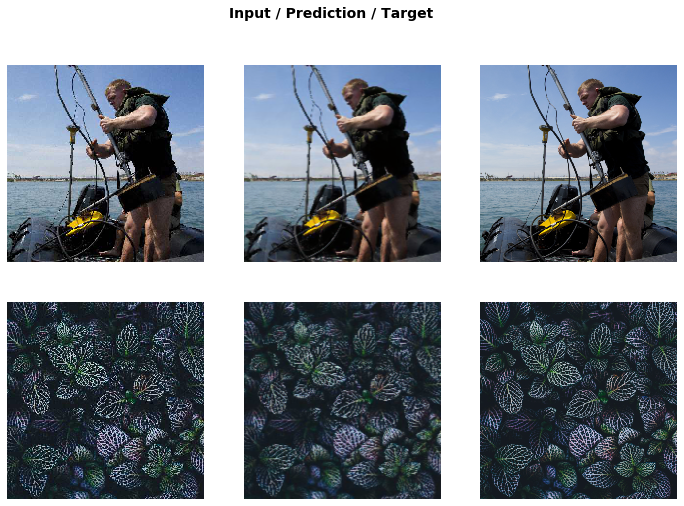

In [ ]:
learn_gen.show_results(rows=5)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


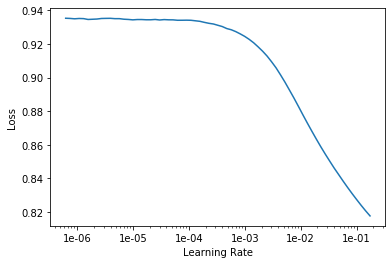

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit(10, (1e-4)/2)

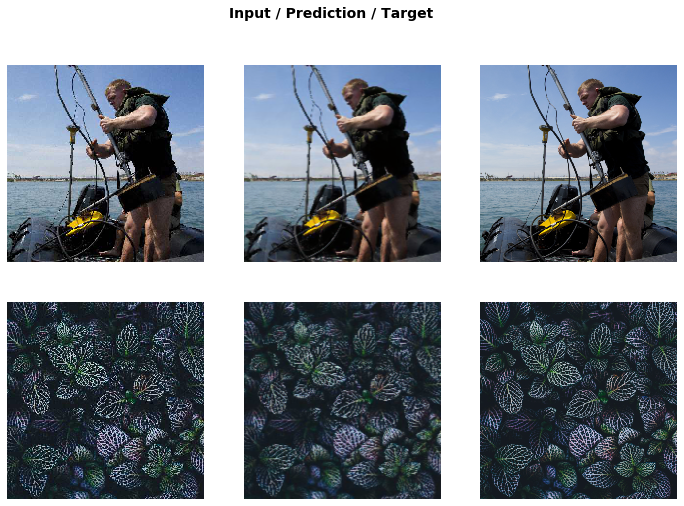

In [ ]:
learn_gen.show_results(rows=2)

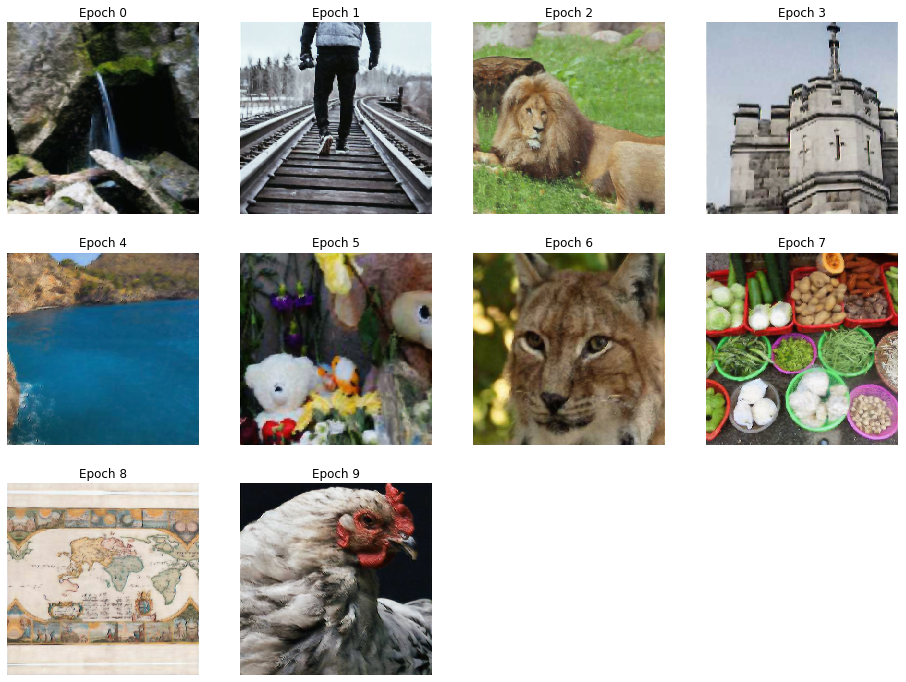

In [ ]:
learn.save('gan-2c')

In [ ]:
learn.save('gan-1c')

In [ ]:
path_gen = "results\\"

In [ ]:
remove_dir(path_gen)
create_dir(path_gen)

In [ ]:
save_preds(data_gen.fix_dl)

Upload the test data


In [ ]:
learn.load('gan-3c');

In [ ]:
source = "resized" 
dest = "GAN" 

In [ ]:
remove_dir(dest)
create_dir(dest)

Successfully removed the directory
Successfully created the directory


In [ ]:
test_data = ImageImageList.from_folder(source)

In [ ]:
learn_gen.data.add_test(test_data, tfm_y=False)

In [ ]:
preds = []
num = len(learn_gen.data.test_ds)

for i in range(num):
  filename = str(learn_gen.data.test_ds.items[i]).split('/')[-1]
  print(filename)
  p = learn_gen.predict(learn_gen.data.test_ds.x[i])
  prediction = p[0]
  print(prediction)
  prediction.save(dest + "/" + filename)
  preds.append(p[0])

1.jpg
Image (3, 400, 400)
2.jpg
Image (3, 400, 400)
3.jpg
Image (3, 400, 400)
4.jpg
Image (3, 400, 400)
5.jpg
Image (3, 400, 400)
6.jpg
Image (3, 400, 400)
7.jpg
Image (3, 400, 400)
8.jpg
Image (3, 400, 400)
9.jpg
Image (3, 400, 400)
10.jpg
Image (3, 400, 400)
11.jpg
Image (3, 400, 400)
12.jpg
Image (3, 400, 400)
13.jpg
Image (3, 400, 400)
14.jpg
Image (3, 400, 400)
15.jpg
Image (3, 400, 400)
16.jpg
Image (3, 400, 400)
17.jpg
Image (3, 400, 400)
18.jpg
Image (3, 400, 400)
19.jpg
Image (3, 400, 400)
20.jpg
Image (3, 400, 400)
21.jpg
Image (3, 400, 400)
22.jpg
Image (3, 400, 400)
23.jpg
Image (3, 400, 400)
24.jpg
Image (3, 400, 400)
25.jpg
Image (3, 400, 400)
26.jpg
Image (3, 400, 400)
27.jpg
Image (3, 400, 400)
28.jpg
Image (3, 400, 400)
29.jpg
Image (3, 400, 400)
30.jpg
Image (3, 400, 400)
31.jpg
Image (3, 400, 400)
32.jpg
Image (3, 400, 400)
33.jpg
Image (3, 400, 400)
34.jpg
Image (3, 400, 400)
35.jpg
Image (3, 400, 400)
36.jpg
Image (3, 400, 400)
37.jpg
Image (3, 400, 400)
38.jpg
Ima